In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_gaussian_observation import ARGaussianObservation
from socialbehavior.transformations.linear import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

# Generate synthetic data

In [28]:
torch.manual_seed(0)

K = 3
D = 2
T = 100

As = [random_rotation(D) for _ in range(K)]
true_tran = LinearTransformation(K=K, d_in=D, d_out=D, As=As)
true_observation = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

# Define a model to fit the data

In [29]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

In [30]:
data.shape

torch.Size([100, 2])

In [31]:
tran.As.shape

torch.Size([3, 2, 2])

# Model fitting

In [32]:
num_iters = 9000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

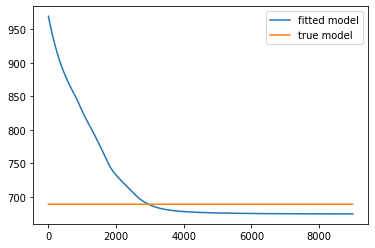

In [33]:
true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss]*num_iters, label='true model')
plt.legend()
plt.show()

# Now, infer the latent states

In [34]:
infer_z = model.most_likely_states(data)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)

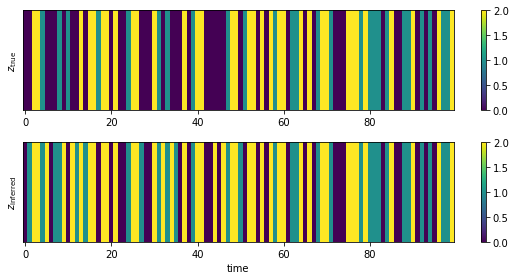

In [35]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(hmm_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

# Generate sample data from the fitted model

In [11]:
sample_z, sample_data = model.sample(T)

In [12]:
sample_data.shape

(100, 2)

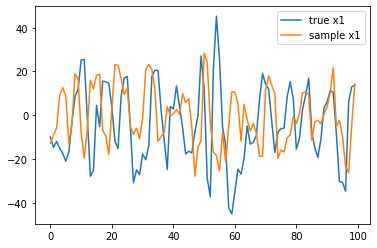

In [13]:
plt.plot(data[:,0].numpy(), label='true x1')
plt.plot(sample_data[:,0], label='sample x1')
plt.legend()
plt.show()

# check prediction

In [14]:
def k_step_prediction(model, model_z, data, k=0):
    """
    Conditioned on the most likely hidden states, make the k-step prediction.
    """
    x_predict_arr = []
    if k == 0:
        for t in range(data.shape[0]):
            x_predict = model.observation.sample_x(model_z[t], data[:t])
            x_predict_arr.append(x_predict)
    else:
        assert k>0
        # neglects t = 0 since there is no history
        for t in range(1, data.shape[0]-k):
            zx_predict = model.sample_x(k, prefix=(model_z[t-1:t], data[t-1:t]))
            assert zx_predict[1].shape == (k, 4)
            x_predict = zx_predict[1][k-1]
            x_predict_arr.append(x_predict)
    x_predict_arr = np.array(x_predict_arr)
    return x_predict_arr

In [15]:
x_predict_cond_z = k_step_prediction(model, z, data)

In [16]:
x_predict_cond_most_likely_z = k_step_prediction(model, hmm_z, data)

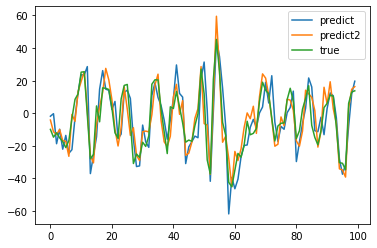

In [17]:
plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()

In [19]:
x_reconstruct = model.sample_condition_on_zs(z, data[0])

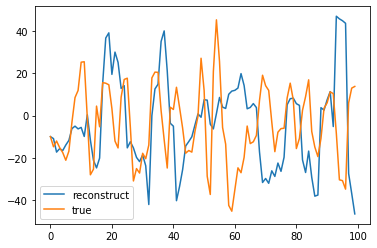

In [21]:
plt.plot(x_reconstruct[:,0], label='reconstruct')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()

In [22]:
x_reconstruct_2 = model.sample_condition_on_zs(hmm_z, data[0])

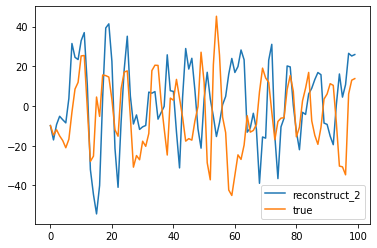

In [23]:
plt.plot(x_reconstruct_2[:,0], label='reconstruct_2')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()

# check bias implementation

In [24]:
As = [random_rotation(D) for _ in range(K)]
true_tran = LinearTransformation(K=K, d_in=D, d_out=D, As=As, use_bias=True)
true_observation = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T, return_np=False)

In [25]:
tran = LinearTransformation(K=K, d_in=D, d_out=D, use_bias=True)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

In [26]:
num_iters = 9000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

In [27]:
tran.params

[tensor([[[ 0.4745,  0.8689],
          [-0.7841,  0.2874]],
 
         [[ 0.0459,  1.0248],
          [-1.0068,  0.0410]],
 
         [[ 0.2610,  0.7744],
          [-1.0082,  0.4600]]], dtype=torch.float64, requires_grad=True),
 tensor([[-0.0347, -0.3512],
         [ 0.0723,  0.4933],
         [ 0.0624,  0.7497]], dtype=torch.float64, requires_grad=True)]